In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import kisomap as kiso
import numpy as np
from scipy.integrate import odeint
import scipy as sp
import sklearn.neighbors as sknn
import sklearn.utils.graph as sksp
from numpy.linalg import norm
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import calinski_harabasz_score
from scipy.sparse.csgraph import dijkstra as graph_shortest_path

In [2]:
with open('datasets/S_Surface.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data,columns=['x','y','z'])

In [3]:
def TotalCurvatureIsomap(dados, k, d):
    # k poderia ser d+1, dado que se sabemos que a variedade de dados é d-dimensional, 
    # podemos assumir que ela está imersa em um espaço d+1-dimensional
    
    n = dados.shape[0]
    m = dados.shape[1]

    # Componentes principais extraídos de cada patch (espaço tangente)
    matriz_pcs = np.zeros((n, m, m))

    # Generate KNN graph
    knnGraph = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
    A = knnGraph.toarray()
    
    # Estimar os espaços tangentes em cada patch através da decomposição 
    # espectral da matriz de covariância do patch
    for i in range(n):       
        vizinhos = A[i, :]
        indices = vizinhos.nonzero()[0]
        if len(indices) == 0:   # Isolated points
            matriz_pcs[i, :, :] = np.eye(m)    # Autovetores nas colunas
        else:
            amostras = dados[indices]
            # Decomposição espectral da matriz de covariância^T
            v, w = np.linalg.eig(np.cov(amostras.T))
            # Sort the eigenvalues
            ordem = v.argsort()
            # Selecionar os d autovetores associados ao d maiores autovalores
            maiores_autovetores = w[:, ordem[::-1]]    
            # Projection matrix
            Wpca = maiores_autovetores  # Autovetores nas colunas
            #print(Wpca.shape)
            matriz_pcs[i, :, :] = Wpca
            #matriz_pcs = n x d x d pode ser visto como um fibrado tangente 
    
    B = A.copy()

    # Calcular as distâncias geodésicas e encontrar os predecessores
    D, predecessors = graph_shortest_path(B, directed=False, return_predecessors=True)

    # Definir o K-Grafo
    for i in range(n):
        # Reconstruir o caminho a partir dos predecessores
        path = [i]
        for j in range(n):
            if B[i, j] > 0:
                # Encontra o caminho de X[i] até X[j]
                while path[-1] != j:
                    path.append(predecessors[j, path[-1]])

                # Inverter o caminho para obter a ordem correta
                path.reverse()

                # O K-ISOMAP proposto é apenas, 
                # delta += norm(matriz_pcs[i, :, :] - matriz_pcs[j, :, :], axis=0)

                # A modificação que encontrei calcula a curvatura total da geodésica de X[i] até X[j]
                # ao longo da geodésica! A versão do K-ISOMAP proposto está considerando apenas
                # a variação do plano tangente aos pontos, enquanto essa versão calcula a variação total
                # da curvatura ao caminhar sobre a geodésica de X[i] até X[j].
                # Está sendo calculado sobre as geodésicas dentro da k-vizinhança.

                delta = 0
                for p in range(len(path)-1):
                    delta += norm(matriz_pcs[path[p], :, :] - matriz_pcs[path[p+1], :, :], axis=0)
            
                ##### Medidas baseadas nas curvaturas principais
                # Deve-se escolher apenas uma das 10 opções a seguir a cada execução

                # Esta é a medida utilizada para resultados preliminares
                B[i, j] = norm(delta)                   # métrica A1 - Normas das curvaturas principais
                # Outras medidas podem ser consideradas, tais como
                #B[i, j] = delta[0]                     # métrica A2 - Curvatura da primeira componente principal
                #B[i, j] = delta[-1]                    # métrica A3 - Curvatura da última componente principal
                #B[i, j] = (delta[0] + delta[-1])/2     # métrica A4 - Média das curvaturas da primeira e última componentes principais
                #B[i, j] = np.sum(delta)/len(delta)     # métrica A5 - Curvatura média
                #B[i, j] = max(delta)                   # métrica A6 - Curvatura máxima
                #B[i, j] = min(delta)                   # métrica A7 - Curvatura mínima
                #B[i, j] = min(delta)*max(delta)        # métrica A8 - Produto entre a mínima e máxima curvaturas
                #B[i, j] = max(delta) - min(delta)      # métrica A9 - Curvatura máxima menos curvatura mínima
                
                ##### métrica 10 - Diferença das projeções nos espaços tangentes
                # Wi = matriz_pcs[i, :, :]
                # Wj = matriz_pcs[j, :, :]
                # ti = np.dot(Wi.T, dados[i, :])
                # tj = np.dot(Wj.T, dados[j, :])
                # B[i, j] = norm(ti - tj)
    
    # Computa os menores caminhos utilizando o K-grafo
    D = graph_shortest_path(B, directed=False, return_predecessors=False)
    # Computes centering matrix H
    H = np.eye(n, n) - (1/n)*np.ones((n, n))
    # Computes the inner products matrix B
    B = -0.5*H.dot(D**2).dot(H)
    #print(np.isnan(B).any())
    #print(np.isinf(B).any())
    # Pode gerar nan ou inf na matriz B
    # Remove infs e nans
    maximo = np.nanmax(B[B != np.inf])   # encontra o maior elemento que não seja inf
    B[np.isnan(B)] = 0
    B[np.isinf(B)] = maximo
    # Eigeendecomposition
    lambdas, alphas = sp.linalg.eigh(B)
    # Sort eigenvalues and eigenvectors
    indices = lambdas.argsort()[::-1]
    lambdas = lambdas[indices]
    alphas = alphas[:, indices]
    # Select the d largest eigenvectors
    lambdas = lambdas[0:d]
    alphas = alphas[:, 0:d]
    # Computes the intrinsic coordinates
    output = alphas*np.sqrt(lambdas)
    
    return output

In [199]:
dados_isomap =  kiso.myIsomap(np.array(df),k=38, d=2)
df_isomap = pd.DataFrame(dados_isomap,columns=['x','y'])

In [200]:
dados_kisomap =  kiso.GeodesicIsomap(np.array(df),k=38, d=2)
df_kisomap = pd.DataFrame(dados_kisomap,columns=['x','y'])

In [204]:
dados_kisomap2 =  TotalCurvatureIsomap(np.array(df),k=38, d=2)
df_kisomap2 = pd.DataFrame(dados_kisomap2,columns=['x','y'])

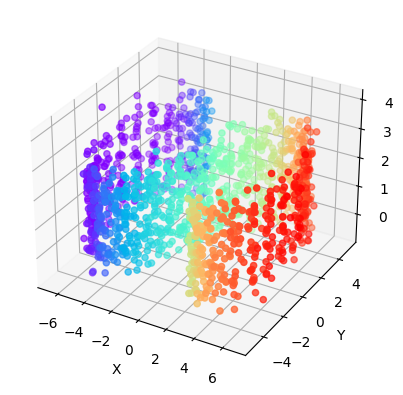

In [6]:
x = df['x']
y = df['y']
z = df['z']

# Configurando o gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lista de cores com base nos valores do eixo Z
# Aqui para diferentes formas e orientações, 
cores = [cm.rainbow(valor) for valor in (x - y.min()) / (x.max() - y.min())]

# Plot
scatter = ax.scatter(x, y, z, c=cores)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

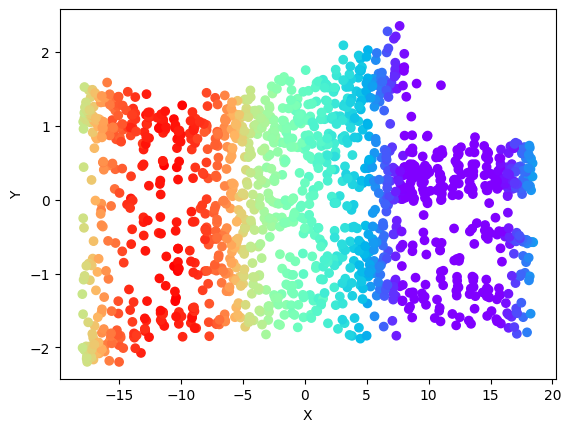

In [206]:
x_2d = df_isomap['x']
y_2d = df_isomap['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

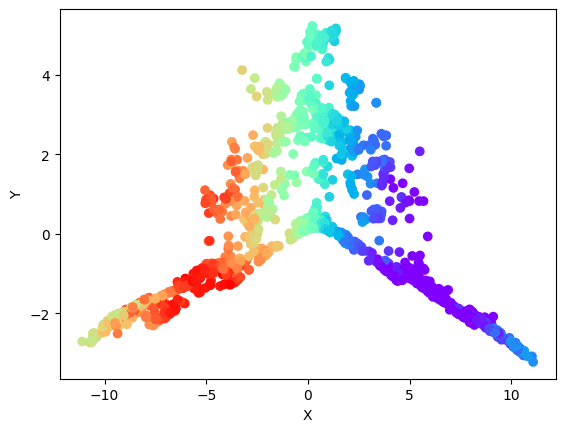

In [207]:
x_2d = df_kisomap['x']
y_2d = df_kisomap['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

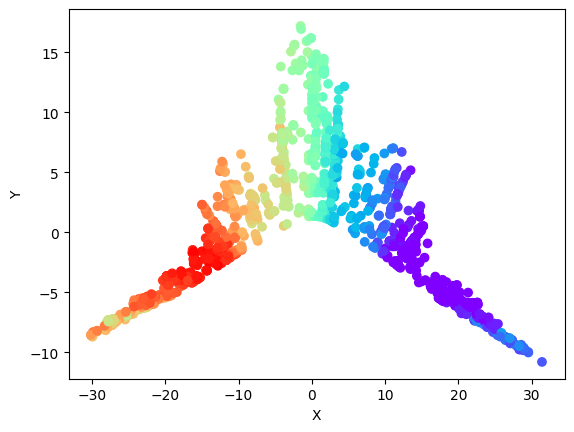

In [208]:
x_2d = df_kisomap2['x']
y_2d = df_kisomap2['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [5]:
num_points = 1000

# Gera coordenadas esféricas
theta = 2 * np.pi * np.random.rand(num_points)
phi = np.arccos(2 * np.random.rand(num_points) - 1)

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

sphere = np.column_stack((x, y, z))

In [6]:
sphere

array([[ 0.31057132, -0.89634804,  0.31639477],
       [ 0.64442105,  0.70906919,  0.28625583],
       [ 0.99898147, -0.00712311,  0.04455661],
       ...,
       [-0.32337132,  0.27254468, -0.90617349],
       [ 0.03256957,  0.16030229, -0.98653049],
       [-0.85754222, -0.37761076,  0.34933002]])

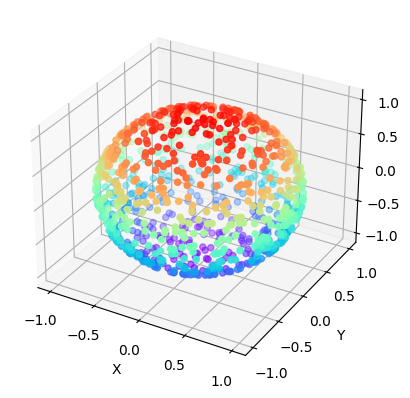

In [7]:
df = sphere

x = df[:,0]
y = df[:,1]
z = df[:,2]

# Configurando o gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lista de cores com base nos valores do eixo Z
# Aqui para diferentes formas e orientações, 
cores = [cm.rainbow(valor) for valor in (z - y.min()) / (z.max() - y.min())]

# Plot
scatter = ax.scatter(x, y, z, c=cores)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

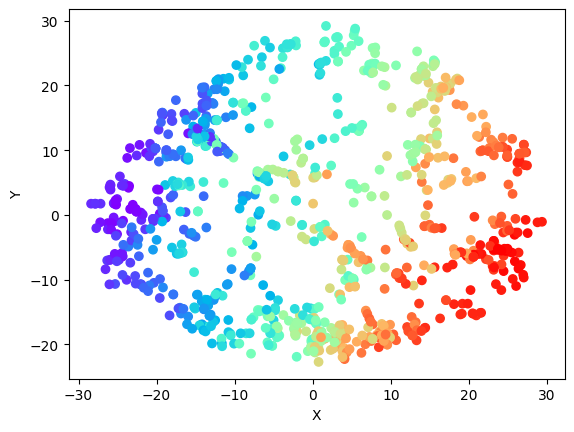

In [8]:
dados_kisomap =  TotalCurvatureIsomap(df,k=9, d=2)
df_kisomap = pd.DataFrame(dados_kisomap,columns=['x','y'])

x_2d = df_kisomap['x']
y_2d = df_kisomap['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

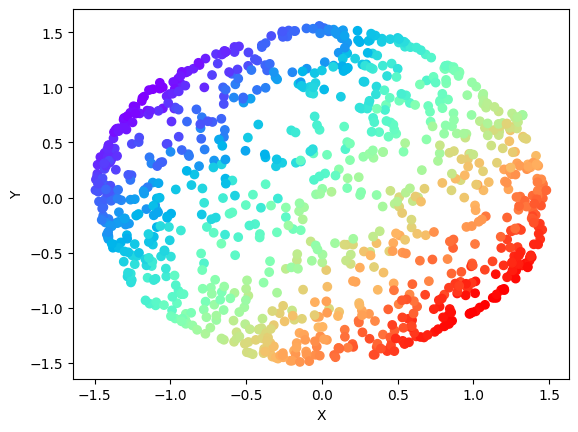

In [9]:
dados_isomap =  kiso.myIsomap(df,k=6, d=2)
df_isomap = pd.DataFrame(dados_isomap,columns=['x','y'])

x_2d = df_isomap['x']
y_2d = df_isomap['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

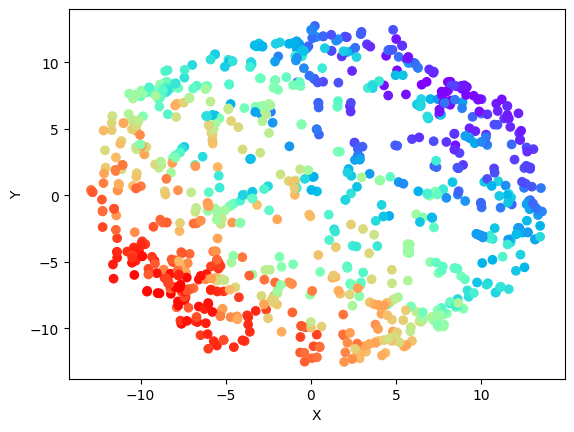

In [10]:
dados_kisomap =  kiso.GeodesicIsomap(df,k=9, d=2)
df_kisomap = pd.DataFrame(dados_kisomap,columns=['x','y'])

x_2d = df_kisomap['x']
y_2d = df_kisomap['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [17]:
dados_pca =  kiso.PCA(df,d=2)

In [22]:
df

,x,y,z
0,2.842864,-3.922140,0.427584
1,3.429950,-4.720349,-0.266878
2,3.814304,-4.915219,0.069473
3,4.268747,-4.398341,-0.101345
4,4.697276,-4.249529,-0.486450
...,...,...,...
1483,-4.693502,3.646837,2.830396
1484,-4.769120,4.664482,3.437207
1485,-3.945192,4.411668,3.088888
1486,-3.410217,4.519825,2.862452


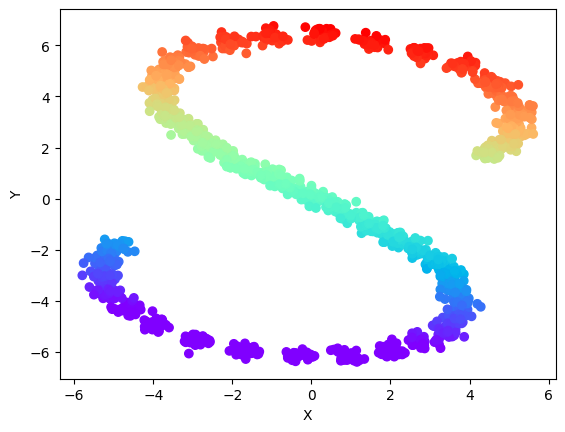

In [7]:
dados_pca =  kiso.PCA(np.array(df),d=2)
df_pca = pd.DataFrame(dados_pca.T,columns=['x','y'])

x_2d = df_pca['x']
y_2d = df_pca['y']

plt.scatter(x_2d, y_2d, c=[cores[i] for i in range(len(x_2d))])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()